In [1]:
# Fangjun Hu

# Preamble
import numpy as np
import math
import scipy
import random
import matplotlib.pyplot as plt
import scipy.linalg as la

from scipy.integrate import ode
from scipy.integrate import odeint
from scipy.linalg import expm, logm, sinm, cosm, svd, hadamard
from scipy.optimize import minimize, fsolve, root # minimization

from numpy.linalg import matrix_rank
from sklearn import svm
from sklearn import linear_model
from copy import deepcopy

# Import qutip
from qutip import *
from qutip.expect import expect_rho_vec

import time

# Font
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

In [2]:
params = {'axes.labelsize': '50',
    'axes.titlesize':'50',
    'xtick.labelsize':'50',
    'ytick.labelsize':'50',
    'lines.linewidth' : 4,
    'legend.fontsize': '40',
    'xtick.major.size': 40.,
    'ytick.major.size': 40.,
    'xtick.minor.size': 20.,
    'ytick.minor.size': 20.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])

In [3]:
# extra minimization
from sklearn import linear_model
# from skopt.utils import use_named_args
# from skopt.space import Real as spaceReal
# from skopt import gp_minimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import math
import h5py

# 1. Generating the Channel Equalization Messages

In [4]:
def EC_Analysis(Output_Feature):
    
    N, K       = Output_Feature.shape                     # Feature matrix of N input data, with K=2^L features
    
    G          = Output_Feature.T @ Output_Feature/N
    D          = np.diag(np.sum(G, axis=0))
    RandomWalk = la.pinv(D) @ G
    
    alpha, r   = la.eig(RandomWalk)
    index      = alpha.argsort()[::-1]
    alpha_sort = np.real(alpha[index])
    r_sort     = np.real(r[:, index])
    nsr        = (1-alpha_sort)/alpha_sort
    
    return nsr, r_sort

In [5]:
def coerce(data):
    """Naively round to the nearest 4PAM symbol."""
    data[np.where(data>=2.0)]  =  3.0
    data[np.where(np.logical_and(data>=0.0, data<2.0))]  =  1.0
    data[np.where(np.logical_and(data>=-2.0, data<0.0))]  = -1.0
    data[np.where(data<=-2.0)] = -3.0
    return data

def Tikhonov_Regularization(X, y, lmd):
    w = np.linalg.solve((X.T @ X + lmd * np.identity(np.shape(X)[1])), X.T @ y)
    return w

def RMSE(w, X, y):
    (m, n) = np.shape(y)
    return np.sqrt((1/(m*n))*np.linalg.norm(y-X@w)**2)


In [6]:
# CE task parameters

SNR = 20. # SNR ratio for CE data
rseed =  17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = 17462) # random number generator

# sampling times for reservoir
tS = 1e-3 # timestep
Thold = 1. # time hold each symbol for

# Convolution Kernel: channel coefficients
chan_coefs = [1.0, 0.18, -0.1, +0.091, -0.05, +0.04, +0.03, +0.01]
N_coefs = len(chan_coefs)

In [7]:
Nsymb_tr = 100 # length of CE dataset (symbols)

tI, tF_tr, nS_tr, nhold = 0, Thold*Nsymb_tr, int(Thold*Nsymb_tr/tS), int(Thold/tS)
tList_tr = np.linspace(tI, tF_tr, nS_tr, endpoint=False)
tsymb_tr = np.linspace(tI, tF_tr, Nsymb_tr, endpoint=False)

# generate true CE data for Training
N_train = 100
MessageSetSymb_train = []
MessageSet_train = []
InputSetSymb_train = []
InputSet_train = []
for r in range(N_train):  
    Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb_tr) - 3 # random integers [-3, -1, 1, 3]
    Y_sig = (Y_symb[:, np.newaxis] @ np.ones((1, int(Thold/tS)))).flatten() # sample at each time point 
    MessageSetSymb_train.append(Y_symb)
    MessageSet_train.append(Y_sig)
    
    f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
    Nscale = np.sqrt(10.0**(-SNR/10.0))
    u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb_tr) # add nonlinearity and noise
    u_sig = (u_symb[:, np.newaxis] @ np.ones((1, nhold))).flatten() # sample at each time point
    InputSetSymb_train.append(u_symb)
    InputSet_train.append(u_sig)
    
MessageSetSymb_train = np.array(MessageSetSymb_train)
MessageSet_train = np.array(MessageSet_train)
InputSetSymb_train = np.array(InputSetSymb_train)

MessageSetSymb_train.shape, MessageSet_train.shape, InputSetSymb_train.shape

((100, 100), (100, 100000), (100, 100))

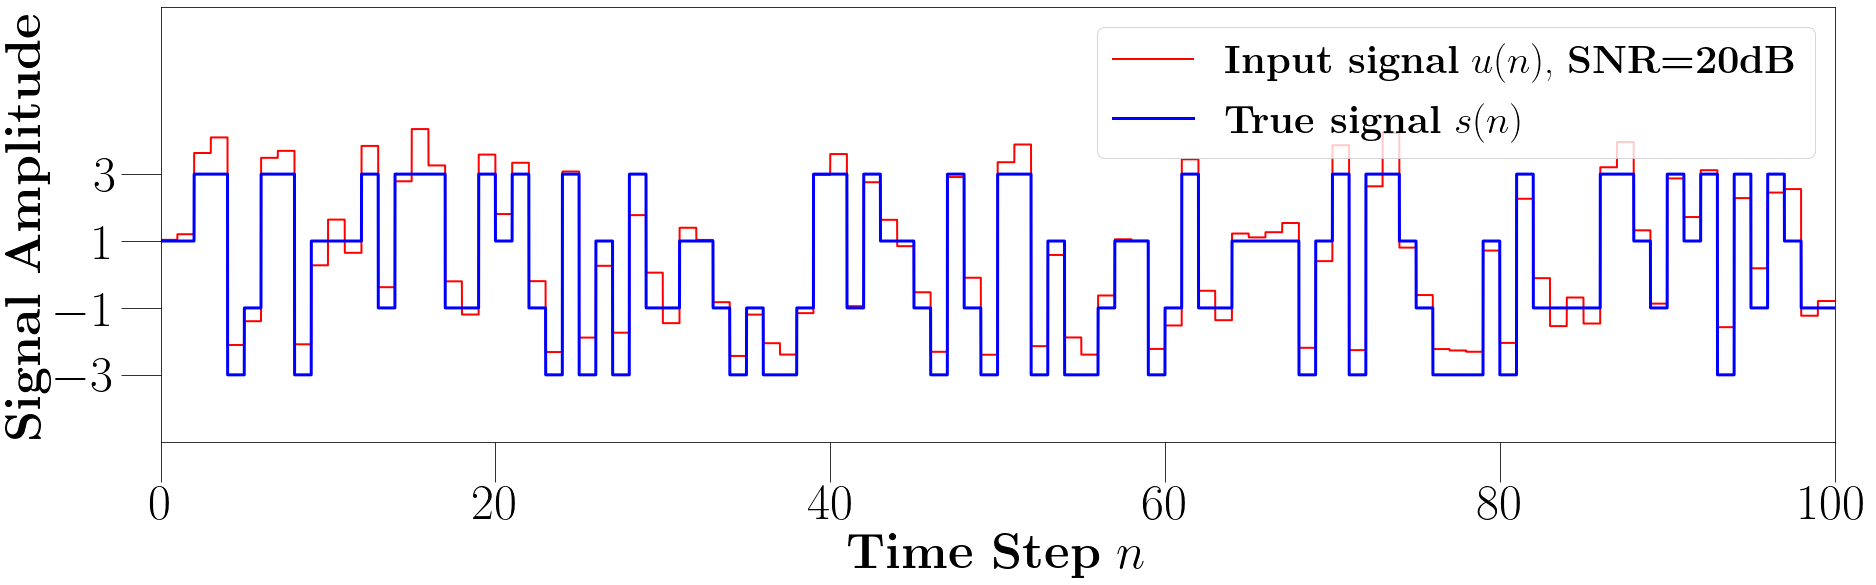

In [8]:
# visualize CE task
fig_CEt, axes = plt.subplots(1, 1, figsize=(30, 8))
ax_CEt = axes
ax_CEt.plot(tList_tr, InputSet_train[0], '-r', linewidth=2, label = '\\textbf{Input signal} $u(n)$, \\textbf{SNR=20dB}')
ax_CEt.plot(tList_tr, MessageSet_train[0], 'b', linewidth=3, label = '\\textbf{True signal} $s(n)$')
ax_CEt.set_xlim([tI, tF_tr])
ax_CEt.set_ylim([-5, 8])
ax_CEt.set_yticks([-3, -1, 3, 1])
ax_CEt.set_ylabel('\\textbf{Signal Amplitude}')
ax_CEt.set_xlabel('\\textbf{Time Step} $n$')
ax_CEt.legend()
# ax_CEt[1].hist(u_sig, bins=40, density=True);
# ax_CEt[1].set_xlim([min(u_sig), max(u_sig)])
# ax_CEt[1].set_ylabel('Signal Distribution')
# ax_CEt[1].set_xlabel('Signal Amplitude')
# plt.title('\\textbf{SNR = 20 dB}')


# 2. System for Quantum RC Simulation

## 2.1 Define States and Operators

In [9]:
def Classical_Entropy(eig_list):
    Entropy = 0
    for i in range(len(eig_list)): 
        if eig_list[i] !=0: 
            Entropy = Entropy - eig_list[i] * np.log(eig_list[i])/np.log(2)
    return Entropy


# Pauli Matrices 

σ_x = np.array([[0,   1], [1 ,  0]]) 
σ_y = np.array([[0, -1j], [1j,  0]]) 
σ_z = np.array([[1,   0], [0 , -1]])
I_2 = np.identity(2, dtype=int)

g = np.array([[0, 0], [0, 1]])
e = np.array([[1, 0], [0, 0]])

ψg = basis(2, 0)
ρg = ψg*ψg.dag()

ψe = basis(2, 1)
ρe = ψe*ψe.dag()


In [31]:
N_system  = 0
N_ancilla = 4
N_qubits  = N_system + N_ancilla
K = 2**N_qubits

X_op = []  # Defined on all qubits
for i in range(N_qubits):
    X = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            X = tensor(X, sigmax())
        else: 
            X = tensor(X, qeye(2))
    X = X.ptrace(range(1, N_qubits + 1))
    X_op.append(X)

Z_op = []  # Defined on all qubits
for i in range(N_qubits):
    Z = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            Z = tensor(Z, sigmaz())
        else: 
            Z = tensor(Z, qeye(2))
    Z = Z.ptrace(range(1, N_qubits + 1))
    Z_op.append(Z)
    
C_op = []  # Defined on all qubits
for i in range(N_qubits):
    C = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            C = tensor(C, create(2))
        else: 
            C = tensor(C, qeye(2))
    C = C.ptrace(range(1, N_qubits + 1))
    C_op.append(C)
    
D_op = []  # Defined on all qubits
for i in range(N_qubits):
    D = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            D = tensor(D, destroy(2))
        else: 
            D = tensor(D, qeye(2))
    D = D.ptrace(range(1, N_qubits + 1))
    D_op.append(D)

len(X_op), len(Z_op), len(C_op), len(D_op)


(4, 4, 4, 4)

In [14]:
M_op = []  # Defined on all qubits
for k in range(2**N_ancilla):
    M = np.zeros((2**N_ancilla, 2**N_ancilla))
    M[k, k] = 1
    M = np.kron(np.eye(2**N_system), M)
    Op = Qobj(M, dims = [[2]*N_qubits, [2]*N_qubits], shape = (2**N_qubits, 2**N_qubits))
    M_op.append(Op)
    
len(M_op)


16

## 2.2 Define Quantum Gates

In [17]:
# Define the necessary function

II      = np.array([[1, 0], [0, 1]])
g_state = np.array([[1, 0], [0, 0]])
e_state = np.array([[0, 0], [0, 1]])
Sigma_x = np.array([[0, 1], [1, 0]])
Sigma_z = np.array([[1, 0], [0, -1]])

def Cnot(nq, cbtb): 
    
    cb, tb = cbtb
    
    Cnot0 = 1
    for i in range(nq): 
        if i != cb and i != tb: 
            Cnot0 = np.kron(Cnot0, II)
        elif i == cb: 
            Cnot0 = np.kron(Cnot0, g_state)
        elif i == tb: 
            Cnot0 = np.kron(Cnot0, II)
            
    Cnot1 = 1
    for i in range(nq): 
        if i != cb and i != tb: 
            Cnot1 = np.kron(Cnot1, II)
        elif i == cb: 
            Cnot1 = np.kron(Cnot1, e_state)
        elif i == tb: 
            Cnot1 = np.kron(Cnot1, Sigma_x)
            
    return Cnot0 + Cnot1

def Rx(θ): 
    return np.array([[np.cos(θ/2), -1j*np.sin(θ/2)], [-1j*np.sin(θ/2), np.cos(θ/2)]])

def Ry(θ): 
    return np.array([[np.cos(θ/2), -np.sin(θ/2)], [np.sin(θ/2), np.cos(θ/2)]])

def Rz(θ): 
    return np.array([[np.exp(-1j*θ/2), 0], [0, np.exp(+1j*θ/2)]])
    
def Classical_Entropy(eig_list):
    L, = eig_list.shape
    Entropy = 0
    for i in range(L): 
        if eig_list[i] !=0: 
            Entropy = Entropy - eig_list[i] * np.log(eig_list[i])/np.log(2)
    return Entropy


In [18]:
def gate_layer(u, a): 
    
    s = a*u
    
    Block_1 = np.eye(2**2)
    Block_1 = np.kron(Rx(s), np.eye(2)) @ Block_1
    Block_1 = Cnot(2, [0, 1]) @ Block_1
    Block_1 = np.kron(Rx(s), Rx(s)) @ Block_1
    Block_1 = Cnot(2, [0, 1]) @ Block_1
    
    Block_2 = np.eye(2**2)
    Block_2 = np.kron(Rx(s), np.eye(2)) @ Block_2
    Block_2 = Cnot(2, [0, 1]) @ Block_2
    Block_2 = np.kron(Rx(s), Rx(s)) @ Block_2
    Block_2 = Cnot(2, [0, 1]) @ Block_2

    return np.kron(Block_1, Block_2)

# 3. Training under QND circuits

In [43]:
# Initial state
sT = time.time()

nS_max = int(10**5)
E = np.eye(K)
ρ0 = np.zeros((K, K))
ρ0[0, 0] = 1

a = 1

N_of = int(2**N_qubits)

Output_Feature_tr   = np.zeros((N_train, Nsymb_tr, N_of))
Output_Feature_tr_S = np.zeros((N_train, Nsymb_tr, N_of))
# Output_Feature_classical = np.zeros((N_train, Nsymb_tr, N_of))

for r in range(N_train):
# for r in range(1):
    
    if (r+1)%10 == 0: 
            print(f'For {r+1}-th training message, elapsed time = {np.round(time.time() - sT, 3)} s.')
            
    # State initialization
    ρSE = deepcopy(ρ0)
    
    for t in range(Nsymb_tr):

        # 1. Apply unitrary evolution on SE qubits
        U = gate_layer(InputSetSymb_train[r, t], a)
        ρSE = U @ ρSE @ (np.conj(U)).T

        # 2. Partial readout
        Prob = np.real(np.diag(ρSE))
        Prob = Prob/np.sum(Prob)
        Output_Feature_tr[r, t] = Prob
        Coins = np.array(random.choices(range(N_of), Prob, k=nS_max))
        for k in range(N_of):
            Output_Feature_tr_S[r, t, k] = (Coins==k).sum()/nS_max
            
        # 3. No-Reset
        ρSE = E * ρSE

print(f'Total time = {np.round(time.time() - sT, 3)} s.')


For 10-th training message, elapsed time = 33.083 s.
For 20-th training message, elapsed time = 73.586 s.
For 30-th training message, elapsed time = 116.902 s.
For 40-th training message, elapsed time = 162.35 s.
For 50-th training message, elapsed time = 201.511 s.
For 60-th training message, elapsed time = 240.336 s.
For 70-th training message, elapsed time = 279.449 s.
For 80-th training message, elapsed time = 318.483 s.
For 90-th training message, elapsed time = 357.585 s.
For 100-th training message, elapsed time = 397.278 s.
Total time = 401.166 s.


Text(0.5, 0, '\\textbf{Time} $n$')

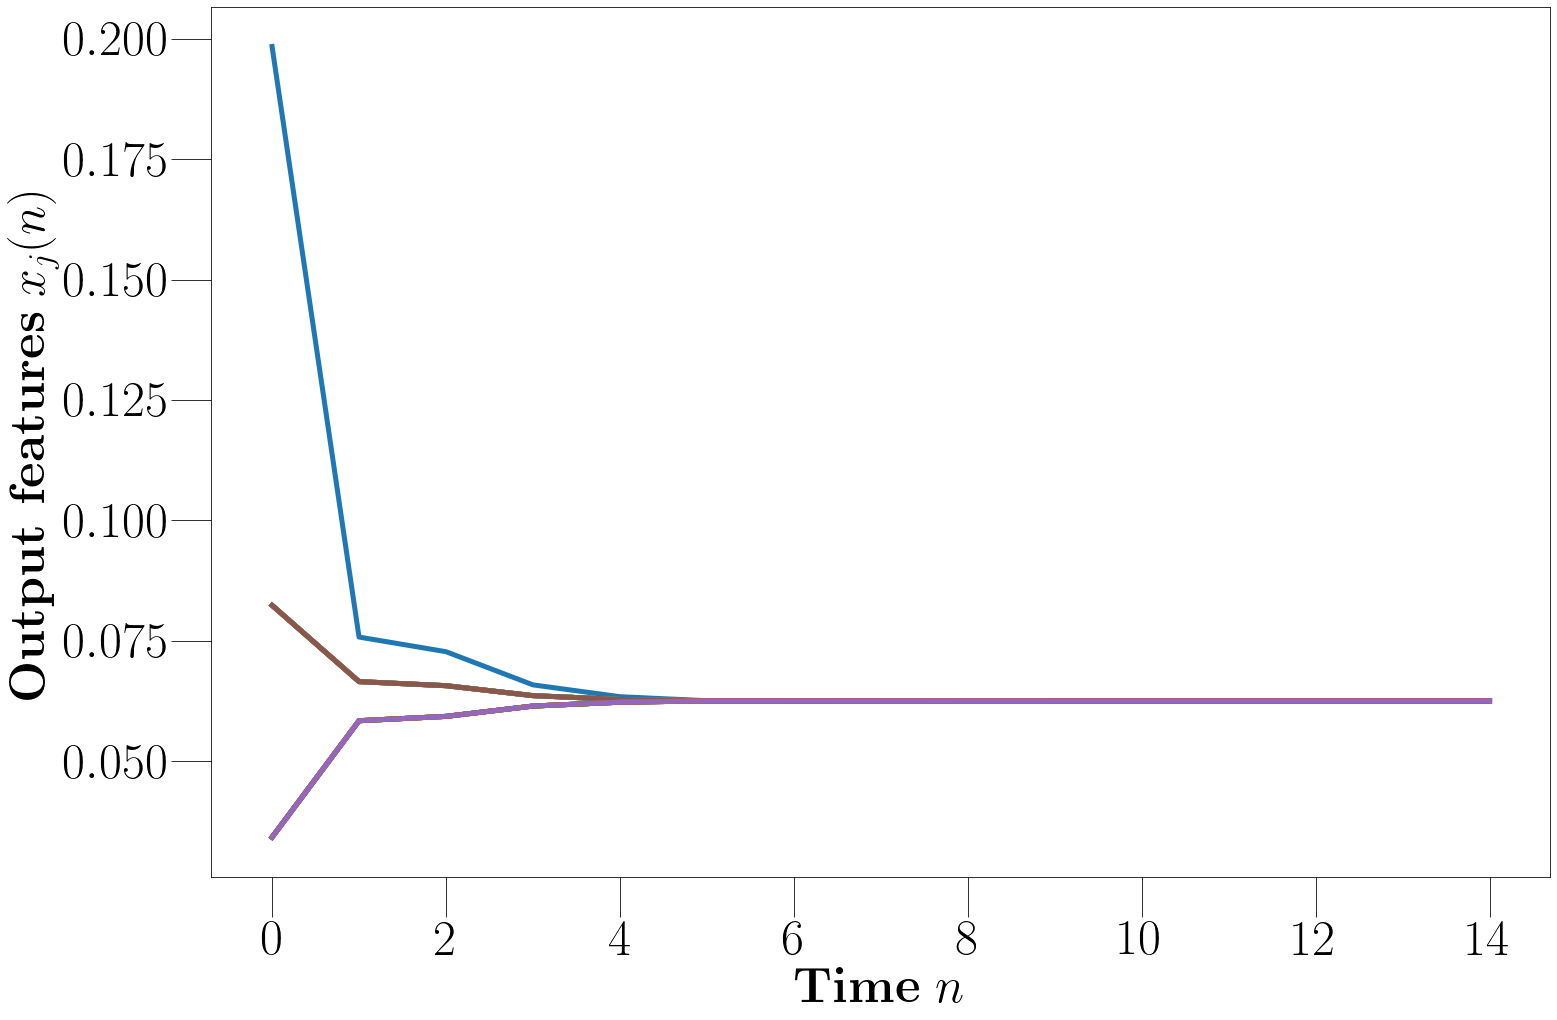

In [46]:
r = 0

fig, axes = plt.subplots(1, 1, figsize=(24, 16))
ax = axes
ax.plot(range(Nsymb_tr)[:15], Output_Feature_tr[r][:15], linewidth = 5)
ax.set_ylabel(r'\textbf{Output features} $x_j(n)$')
ax.set_xlabel(r'\textbf{Time} $n$')

In [47]:
Output_Feature_train = Output_Feature_tr_S
Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb_tr, N_of))
MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb_tr, 1))
# lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)
lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
accuracy = lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
print(1 - accuracy)
train_error_Reset = 1 - accuracy


0.7223999999999999


In [54]:
train_error_QND = 0.7223999999999999

# 4. Testing under QND circuits

In [48]:
Nsymb_ts = 5000 # length of CE dataset (symbols)

tI, tF_ts, nS_ts, nhold = 0, Thold*Nsymb_ts, int(Thold*Nsymb_ts/tS), int(Thold/tS)
tList_ts = np.linspace(tI, tF_ts, nS_ts, endpoint=False)
tsymb_ts = np.linspace(tI, tF_ts, Nsymb_ts, endpoint=False)
    
# generate true CE data for Training
N_test = 8
MessageSetSymb_test = []
MessageSet_test = []
InputSetSymb_test = []
InputSet_test = []
for r in range(N_test):  
    Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb_ts) - 3 # random integers [-3, -1, 1, 3]
    Y_sig = (Y_symb[:, np.newaxis] @ np.ones((1, int(Thold/tS)))).flatten() # sample at each time point 
    MessageSetSymb_test.append(Y_symb)
    MessageSet_test.append(Y_sig)
    
    f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
    Nscale = np.sqrt(10.0**(-SNR/10.0))
    u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb_ts) # add nonlinearity and noise
    u_sig = (u_symb[:, np.newaxis] @ np.ones((1, nhold))).flatten() # sample at each time point
    InputSetSymb_test.append(u_symb)
    InputSet_test.append(u_sig)
    
MessageSetSymb_test = np.array(MessageSetSymb_test)
MessageSet_test = np.array(MessageSet_test)
InputSetSymb_test = np.array(InputSetSymb_test)


MessageSetSymb_test.shape, MessageSet_test.shape, InputSetSymb_test.shape

((8, 5000), (8, 5000000), (8, 5000))

In [50]:
# Initial state
sT = time.time()

Output_Feature_ts   = np.zeros((N_test, Nsymb_ts, N_of))
Output_Feature_ts_S = np.zeros((N_test, Nsymb_ts, N_of))

for r in range(N_test):

    print(f'For {r+1}-th message, elapsed time = {np.round(time.time() - sT, 3)} s.')
            
        # State initialization
    ρSE = deepcopy(ρ0)
    
    for t in range(Nsymb_ts):

        # 1. Apply unitrary evolution on SE qubits
        U = gate_layer(InputSetSymb_test[r, t], a)
        ρSE = U @ ρSE @ (np.conj(U)).T

        # 2. Partial readout
        Prob = np.real(np.diag(ρSE))
        Prob = Prob/np.sum(Prob)
        Output_Feature_ts[r, t] = Prob
        Coins = np.array(random.choices(range(N_of), Prob, k=nS_max))
        for k in range(N_of):
            Output_Feature_ts_S[r, t, k] = (Coins==k).sum()/nS_max
            
        # 3. No-Reset
        ρSE = E * ρSE

print(f'Total time = {np.round(time.time() - sT, 3)} s.')


For 1-th message, elapsed time = 0.005 s.
For 2-th message, elapsed time = 191.075 s.
For 3-th message, elapsed time = 383.945 s.
For 4-th message, elapsed time = 579.73 s.
For 5-th message, elapsed time = 782.029 s.
For 6-th message, elapsed time = 985.196 s.
For 7-th message, elapsed time = 1184.873 s.
For 8-th message, elapsed time = 1383.258 s.
Total time = 1578.885 s.


In [51]:
Output_Feature_ts.shape, MessageSetSymb_test.shape, Nsymb_ts

((8, 5000, 16), (8, 5000), 5000)

In [52]:
nts_used_list = np.linspace(1, 5000, 5000)

In [53]:
Output_Feature_test = Output_Feature_ts_S

Test_acc = np.zeros((N_test, len(nts_used_list)))
Test_err = np.zeros((N_test, len(nts_used_list)))

for r in range(N_test):
    for i in range(len(nts_used_list)):
        nts_used = int(nts_used_list[i])
        Output_Feature_test_stack = Output_Feature_test[r, :nts_used, :].reshape((nts_used, N_of))
        MessageSetSymb_test_stack = MessageSetSymb_test[r, :nts_used].reshape((nts_used, 1))
        accuracy = lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0])
        Test_acc[r, i] = 1 - accuracy
        Test_err[r, i] = (1 - accuracy) * nts_used

# 5. Formal Plot

Simulation of NISQRC (for comparison) can be founded in file "Channel_Equalization_Streaming_Test.ipynb"

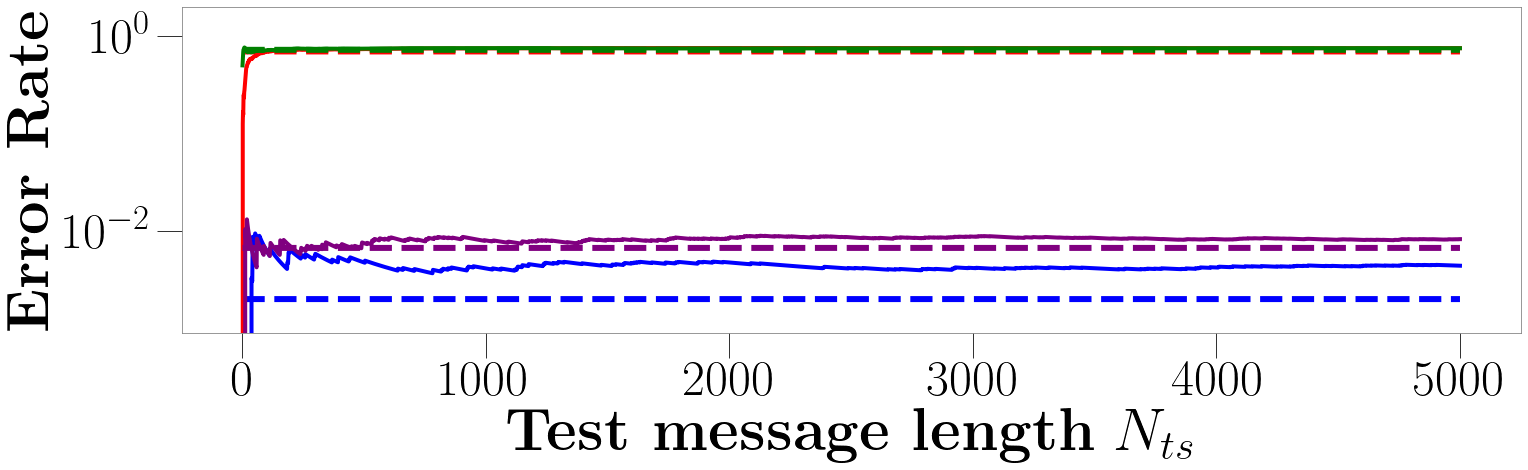

In [64]:
params = {'axes.labelsize': '60',
    'axes.titlesize':'60',
    'xtick.labelsize':'50',
    'ytick.labelsize':'50',
    'lines.linewidth' : 4,
    'legend.fontsize': '25',
    'xtick.major.size': 25.,
    'ytick.major.size': 25.,
    'xtick.minor.size': 15.,
    'ytick.minor.size': 15.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])


path = '/NISQRC-Codes/Data'

filename = 'ER_S100000_Reset_Test_acc.npy'
data = np.load(path + filename)
Test_acc_Reset = np.array(data)

filename = 'ER_S100000_NoReset_Test_acc.npy'
data = np.load(path + filename)
Test_acc_NoReset = np.array(data)

filename = 'ER_S100000_Reset_T1_1e1_Test_acc.npy'
data = np.load(path + filename)
Test_acc_Reset_T1_1e1 = np.array(data)

filename = 'ER_S100000_QND_Test_acc.npy'
data = np.load(path + filename)
Test_acc_QND = np.array(data)

nts_used_list = np.linspace(1, 5000, 5000)
train_error_Reset        = 0.0020
train_error_NoReset      = 0.6952
train_error_Reset_T1_1e1 = 0.0067
train_error_QND          = 0.7224

fig, axes = plt.subplots(1, 1, figsize=(24, 6))
ax = axes
x_axis = nts_used_list

ax.plot(x_axis, np.mean(Test_acc_Reset, axis=0), linewidth = 4, color = 'blue',  label = r'\textbf{Testing, w/ Reset}')
ax.plot(x_axis, [train_error_Reset]*len(x_axis), linewidth = 6, color = 'blue', ls = '--', label = r'\textbf{Training, w/ Reset}')

ax.plot(x_axis, np.mean(Test_acc_NoReset, axis=0), linewidth = 4, color = 'red', label = r'\textbf{Testing, w/o Reset}')
ax.plot(x_axis, [train_error_NoReset]*len(x_axis), linewidth = 6, color = 'red', ls = '--', label = r'\textbf{Training, w/o Reset}')

ax.plot(x_axis, np.mean(Test_acc_Reset_T1_1e1, axis=0), linewidth = 4, color = 'purple', label = r'\textbf{Testing, w/ Reset and Decay}')
ax.plot(x_axis, [train_error_Reset_T1_1e1]*len(x_axis), linewidth = 6, color = 'purple', ls = '--', label = r'\textbf{Training, w/ Reset and Decay}')

ax.plot(x_axis, np.mean(Test_acc_QND, axis=0), linewidth = 4, color = 'green', label = r'\textbf{Testing, QND}')
ax.plot(x_axis, [train_error_QND]*len(x_axis), linewidth = 6, color = 'green', ls = '--', label = r'\textbf{Training, QND}')

ax.set_ylim([9e-4, 2])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1])
ax.set_yticklabels([1e-3, 1e-2, 1e-1, 1])
ax.set_yscale('log')
ax.set_ylabel(r'\textbf{Error Rate}')
ax.set_xlabel(r'\textbf{Test message length} $N_{ts}$')
# ax.legend(ncol=3)
ax.spines[['bottom', 'top', 'right', 'left']].set_color('gray')